In [ ]:
pip install langgraph langchain langchain_openai langchain_experimental langsmith pandas

In [ ]:
from dotenv import load_dotenv

load_dotenv()

In [32]:
import sqlite3
from typing import Annotated
from langchain_core.tools import tool
from langchain_experimental.tools import PythonREPLTool
import pandas as pd
from datetime import datetime, timedelta

# Initialize SQLite database with some tables
def init_database():
    conn = sqlite3.connect('warehouse2.db')
    c = conn.cursor()

    # Create tables
    c.execute('''CREATE TABLE IF NOT EXISTS inventory
                 (product_id TEXT PRIMARY KEY,
                  name TEXT,
                  quantity INTEGER,
                  reorder_point INTEGER,
                  unit_price REAL)''')

    c.execute('''CREATE TABLE IF NOT EXISTS orders
                 (order_id TEXT PRIMARY KEY,
                  order_date TIMESTAMP,
                  status TEXT,
                  total_amount REAL)''')

    c.execute('''CREATE TABLE IF NOT EXISTS order_items
                 (order_id TEXT,
                  product_id TEXT,
                  quantity INTEGER,
                  FOREIGN KEY(order_id) REFERENCES orders(order_id),
                  FOREIGN KEY(product_id) REFERENCES inventory(product_id))''')

    # Insert sample data
    c.execute('DELETE FROM inventory')
    c.execute('DELETE FROM orders')
    c.execute('DELETE FROM order_items')

    # Sample inventory
    inventory_data = [
        ('SKU001', 'Gaming Laptop', 45, 20, 999.99),
        ('SKU002', 'Wireless Mouse', 150, 50, 29.99),
        ('SKU003', 'Mechanical Keyboard', 5, 30, 89.99),
        ('SKU004', 'Monitor 27"', 30, 15, 299.99),
        ('SKU005', 'USB-C Hub', 10, 40, 49.99)
    ]
    c.executemany('INSERT INTO inventory VALUES (?,?,?,?,?)', inventory_data)

    # Sample orders
    for i in range(1, 21):  # Create 20 sample orders
        order_id = f'ORD{i:03d}'
        order_date = datetime.now() - timedelta(days=i)
        status = ['Pending', 'Processing', 'Shipped', 'Delivered'][i % 4]
        c.execute('INSERT INTO orders VALUES (?,?,?,?)',
                 (order_id, order_date, status, 0))  # Total will be updated

        # Add 1-3 items to each order
        for j in range(1, (i % 3) + 2):
            product_id = f'SKU{(i + j) % 5 + 1:03d}'
            quantity = (i + j) % 5 + 1
            c.execute('INSERT INTO order_items VALUES (?,?,?)',
                     (order_id, product_id, quantity))

    conn.commit()
    conn.close()

# Initialize the database
init_database()


C:\Users\SivaPrasad\AppData\Local\Temp\ipykernel_7648\1638020371.py:54: DeprecationWarning: The default datetime adapter is deprecated as of Python 3.12; see the sqlite3 documentation for suggested replacement recipes
  c.execute('INSERT INTO orders VALUES (?,?,?,?)',


In [33]:
from langchain.sql_database import SQLDatabase

from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain.agents import create_sql_agent
from  langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")
# Create database connection
db = SQLDatabase.from_uri("sqlite:///warehouse2.db")

# Create the SQL toolkit
sql_toolkit = SQLDatabaseToolkit(db=db,llm=llm)


# Create tool instances
python_repl = PythonREPLTool()

In [34]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel

members = ["InventoryManager", "OrderProcessor", "AnalyticsManager"]
tasks_handled = [
    "InventoryManager can check stock levels, update inventory, and manage reordering",
    """OrderProcessor can process orders, update order status, and manage order fulfillmentit
    can verify inventory availability""",
    "AnalyticsManager can analyze sales trends, inventory turnover, and generate reports"
]

member_tasks = {member: task for member, task in zip(members, tasks_handled)}

system_prompt = (
    "You are a warehouse operations supervisor managing these workers: {members}."
    " Below are the tasks handled by each worker:\n" +
    "\n".join([f"{member}: {task}" for member, task in member_tasks.items()]) + "\n"
    " Given the following request, determine which worker should act next."
    " When all necessary tasks are completed, respond with FINISH."
)

options = ["FINISH"] + members


In [35]:
class routeResponse(BaseModel):
    next: str

# Set up the supervisor prompt
prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="messages"),
    ("system", "Given the conversation above, who should act next?"
     " Or should we FINISH? Select one of: {options}"),
]).partial(options=str(options), members=", ".join(members))

# Create the supervisor agent


def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

In [37]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

# Create specialized agents with their tools
inventory_agent = create_react_agent(
    llm,
    [python_repl, *sql_toolkit.get_tools()],
    prompt="""You are the Inventory Manager. You can:
    1. Query inventory levels using SQL
    2. Update inventory quantities
    3. Check items below reorder point
    4. if generating code, make sure to use the correct , make sure that code returns expected value finally.
    think properly before generating code and generate all the required code at once.

    Important Instructions:
    - Always end your response with a clear CONCLUSION: stating what you found and any actions taken
    - When checking inventory, provide specific numbers
    - For updates, confirm the before and after quantities
    - Keep responses focused and concise
    - Use proper SQL syntax and verify data before updates

    Example format:
    *Analysis/Actions taken*
    CONCLUSION: Found X items below reorder point. Updated inventory for item Y from A to B units."""
, debug=False
)
order_agent = create_react_agent(
    llm,
    [python_repl, *sql_toolkit.get_tools()],
    prompt="""You are the Order Processor. You can:
    1. Process new orders
    2. Update order status
    3. Check order details
    4. Verify inventory availability
    Important Instructions:
    - Always end your response with a clear CONCLUSION: stating what you found and any actions taken
    - Verify inventory before processing orders
    - For order updates, confirm the new status
    - Provide specific quantities and order details
    - Keep responses focused and concise
    Example format:
    *Analysis/Actions taken*
    CONCLUSION: Order XYZ processed successfully. Updated status from A to B. Inventory adjusted."""
, debug=False
)

analytics_agent = create_react_agent(
    llm,
    [python_repl, *sql_toolkit.get_tools()],
    prompt="""You are the Analytics Manager. You can:
    1. Analyze sales trends
    2. Generate inventory reports
    3. Calculate key metrics
    4. Provide recommendations

    Important Instructions:
    - Always end your response with a clear CONCLUSION: stating your findings and recommendations
    - Provide specific numbers and insights
    - Keep responses focused and concise
    - Use clear visualizations when needed

    Example format:
    *Analysis performed*
    CONCLUSION: Analysis shows X trend over Y period. Recommend taking Z action."""
,debug=False
)


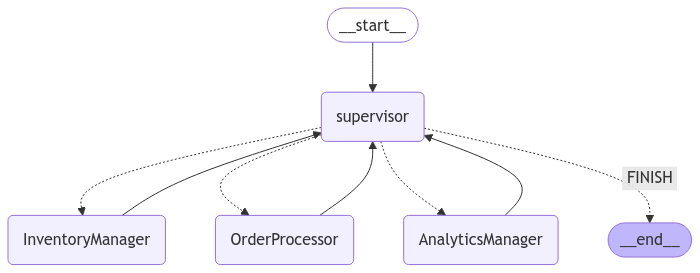

In [38]:
from langchain_core.messages import HumanMessage,BaseMessage
import functools
from typing import Sequence
from typing_extensions import TypedDict
import operator


def agent_node(state, agent, name):
    result = agent.invoke(state)
    print(f"{name} says: {result}")
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }


class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


# Create agent nodes
inventory_node = functools.partial(agent_node, agent=inventory_agent, name="InventoryManager")
order_node = functools.partial(agent_node, agent=order_agent, name="OrderProcessor")
analytics_node = functools.partial(agent_node, agent=analytics_agent, name="AnalyticsManager")

# Set up workflow
workflow = StateGraph(AgentState)
workflow.add_node("InventoryManager", inventory_node)
workflow.add_node("OrderProcessor", order_node)
workflow.add_node("AnalyticsManager", analytics_node)
workflow.add_node("supervisor", supervisor_agent)

# Add edges
for member in members:
    workflow.add_edge(member, "supervisor")

conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    conditional_map
)
workflow.add_edge(START, "supervisor")

# Compile the graph
graph = workflow.compile()

from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [39]:
# Example usage
queries = [
    #"Check all products below their reorder point and create a restock report",
    # "Process order ORD001 and update inventory accordingly",
    # "Analyze the top 5 selling products from the last 20 orders and visualize the results",
     "Check if we have enough inventory to fulfill order ORD005 and process it if possible"
]

for query in queries:
    print(f"\nProcessing query: {query}")
    print("-" * 50)
    for query in queries:
        print(f"\nProcessing query: {query}")
        print("-" * 50)
        result = graph.invoke(
            {
                "messages": [
                    HumanMessage(content=query)
                ]
            }
        )
        print("\nFinal Result:")

        from IPython.display import Markdown
        Markdown(result['messages'][-1].content)

    # for s in graph.stream(
    #     {
    #         "messages": [
    #             HumanMessage(content=query)
    #         ]
    #     }
    # ):
    #     if "__end__" not in s:
    #         print(s)
    #         print("----")


Processing query: Check if we have enough inventory to fulfill order ORD005 and process it if possible
--------------------------------------------------

Processing query: Check if we have enough inventory to fulfill order ORD005 and process it if possible
--------------------------------------------------
InventoryManager says: {'messages': [HumanMessage(content='Check if we have enough inventory to fulfill order ORD005 and process it if possible', additional_kwargs={}, response_metadata={}, id='4d395b2c-59dc-43ba-97f0-98d1f8918fce'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_WrPMj12n2k0vC0l5WqaFNu2z', 'function': {'arguments': '{}', 'name': 'sql_db_list_tables'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 565, 'total_tokens': 578, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_